In [17]:
#import libraries
import zipfile
import os
import cv2
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from keras.models import save_model

In [2]:
#importing dataset (extract dataset from zipfile)
path = '/content/drive/MyDrive/Computer Vision Masterclass/Datasets/homer_bart_1.zip'   #path of dataset zip file
zip_obj = zipfile.ZipFile(path, mode ='r')  #read mode
zip_obj.extractall('./')    #extract to current path
zip_obj.close() #close to release memory

In [3]:
directory = '/content/homer_bart_1'  #path of extracted dataset (current location)
files = [os.path.join(directory, f) for f in sorted(os.listdir(directory))] #contains paths of each images

In [4]:
#data preprocessing
height, width = 128, 128   #since all images are of different shapes reshape them to this shape
images =[]  #pixel values of all images
classes = []    #class of all images

for image_path in files:
    #print(image_path)

    try:    #exception handling for the irrelevant file DSstore that is in the directory (shortly can delete the file)
        image = cv2.imread(image_path)  #read image one by one
        (H, W) = image.shape[:2]    #since this is RGB image need only first two values are height and weight
    except:
        continue
    
    image = cv2.resize(image, (width, height))  #resize the image to 128,128,3
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to gray scale
    #cv2.imshow('', image)
    #cv2.waitKey(0)
    image = image.ravel()       #convert matrix to vector to feed to input layer
    images.append(image)    #store all vector representation of images
    
    #print(os.path.normpath(image_path)) #normpath removes redundant separator to extract filename
    #print(os.path.basename(os.path.normpath(image_path)))   #basename - only name (without location)
    
    image_name = os.path.basename(os.path.normpath(image_path)) #extract only filename
    
    if(image_name.startswith('b')): #encoding categorical data 
        class_name = 0  #bart - 0
    else:
        class_name = 1  #homer -1

    classes.append(class_name)  #store all class_names
    #print(class_name)

#convert images and classes to np representation
X = np.asarray(images)  #or can use X = np.array(images)
Y = np.asarray(classes) #or can use Y = np.array(classes)

(array([0, 1]), array([160, 109]))


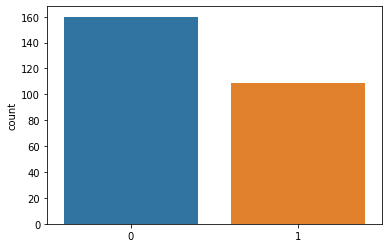

In [5]:
#visualise counts
sns.countplot(x=Y)  #dis;play barchart
print(np.unique(Y, return_counts=True)) #to see number of images in each class

In [6]:
#normalising the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)                 #or just divide X by 255

In [7]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1)    #20% data as test data

In [8]:
#number of neurones in hidden layer = (inp layer + out layer )/ 2
#(16384 + 2) /2

#building the model
network1 = tf.keras.models.Sequential()
network1.add(tf.keras.layers.Dense(input_shape=(X_train.shape), units = 8193, activation='relu'))
network1.add(tf.keras.layers.Dense(units = 8193, activation='relu'))    #2nd layer
network1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  #since binary classification sigmoid activation

#visualise the model
network1.summary()

#compile model
network1.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

#train
history = network1.fit(X_train, Y_train, epochs = 50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 215, 8193)         134242305 
_________________________________________________________________
dense_1 (Dense)              (None, 215, 8193)         67133442  
_________________________________________________________________
dense_2 (Dense)              (None, 215, 1)            8194      
Total params: 201,383,941
Trainable params: 201,383,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 11s 1s/step - loss: 113.6558 - accuracy: 0.5163
Epoch 2/50
7/7 [==============================] - 10s 1s/step - loss: 24.1528 - accuracy: 0.4791
Epoch 3/50
7/7 [==============================] - 10s 1s/step - loss: 5.2671 - accuracy: 0.5302
Epoch 4/50
7/7 [==============================] - 10s 1s/step - loss: 0.7920 - ac

dict_keys(['loss', 'accuracy'])


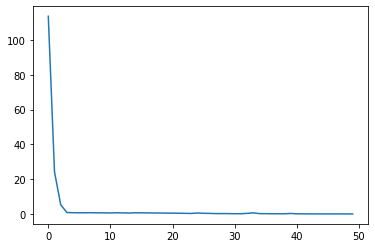

In [9]:
#model evaluation
print(history.history.keys())
plt.plot(history.history['loss']);

In [10]:
#testing
predictions = network1.predict(X_test)

In [11]:
#convert predictions (probabilities) to classes
predictions = (predictions > 0.5) #threshold = 0.5

In [12]:
#test evaluation
print('Accuracy :', accuracy_score(predictions, Y_test)*100)
cm = confusion_matrix(Y_test, predictions)

Accuracy : 72.22222222222221


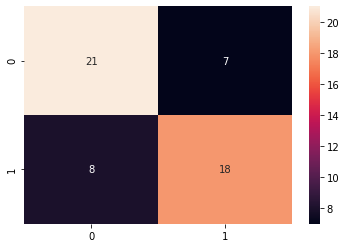

In [13]:
#display heatmap
sns.heatmap(cm, annot=True);

In [14]:
#classification report
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74        28
           1       0.72      0.69      0.71        26

    accuracy                           0.72        54
   macro avg       0.72      0.72      0.72        54
weighted avg       0.72      0.72      0.72        54



In [15]:
#save json model structure
model_json = network1.to_json()   #convert model to json format
with open('network1.json', 'w') as json_file:
  json_file.write(model_json) #write the json format of model to network1.json file

In [18]:
#save model weights
network1_saved = save_model(network1, '/content/weights1.hdf5')

In [30]:
#read stored json model structure
with open('network1.json', 'r') as json_file:
  json_saved_model = json_file.read()

In [31]:
#build model from json structure
network1_loaded = tf.keras.models.model_from_json(json_saved_model)   #convert json format of stored model to model
network1_loaded.load_weights('weights1.hdf5') #load weights stored before
network1_loaded.compile(optimizer='Adam', loss='binary_crossentropy', metrics =['accuracy']) #setting exact optimizer, loss, metrics

In [33]:
#model summary
network1_loaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 215, 8193)         134242305 
_________________________________________________________________
dense_1 (Dense)              (None, 215, 8193)         67133442  
_________________________________________________________________
dense_2 (Dense)              (None, 215, 1)            8194      
Total params: 201,383,941
Trainable params: 201,383,941
Non-trainable params: 0
_________________________________________________________________


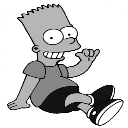

Bart


In [37]:
#single image prediction
test_image = X_test[0]
test_image = scaler.inverse_transform(test_image.reshape(1, -1))
cv2_imshow(test_image.reshape(width,height))
if(network1_loaded.predict(test_image)[0][0] < 0.5):
  print('Bart')
else:
  print('Homer')